In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from wanna_buy_house.data import final_treatment
from wanna_buy_house.utils import final_transformer

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [4]:
data_cleaned = final_treatment()
data = final_transformer(data_cleaned)
data

get_data 0.28


,Loan.Status,Credit.Minus.Loan,Years.current_job_enc,Tax.Liens.Enc,Leverage,Bankruptcies.enc,Years.since.last.delinquent,Loan.vs.Income,Term.Encoded,Number.of.Open.Accounts.Labeled,...,H.O.Home Mortgage,H.O.Own Home,H.O.Rent,Purp.Business Loan,Purp.Buy House,Purp.Buy a Car,Purp.Debt Consolidation,Purp.Home Improvements,Purp.Medical Bills,Purp.Other
0,1,1,6,0,0.190000,0,1,0.187495,0.0,2,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,1,4,0,0.301998,1,0,0.207542,0.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,1,10,0,0.085501,0,0,0.075625,0.0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1,0,5,0,0.127000,1,0,0.165112,0.0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,0,0,10,0,0.056798,0,0,0.075445,1.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60794,1,0,6,0,0.047101,0,0,0.119199,0.0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60795,1,1,1,0,0.197000,0,0,0.100010,0.0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60797,1,1,10,0,0.292000,0,0,0.279996,1.0,2,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60800,0,0,3,0,0.103000,0,1,0.200004,0.0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
#Converted Year.Credit.History.Labeled from category to int64

data['Year.Credit.History.Labeled'] = data['Year.Credit.History.Labeled'].astype('int64')

In [6]:
# Defining variables considering results of feature selection

X = data.drop(columns=['Loan.Status', 'Tax.Liens.Enc',
                      'Bankruptcies.enc', 'Number.of.Open.Accounts.Labeled'])
y = data['Loan.Status'] 

# Train Test Split both datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# GERACAO DE DADOS ARTIFICIAIS PARA A CATEGORIA DO TARGET MINORITARIO 0 A PARTIR DOS DADOS EXISTENTES
sm = SMOTE()
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

## 1. Random Forest

## 1.1. The model

In [7]:
# Random forest model with feature selection
forest = RandomForestClassifier()

# Model fit, score and score metrics
forest.fit(X_train_bal, y_train_bal)
forest.score(X_test, y_test)
y_pred_forest = forest.predict(X_test)

# Cross validate model
cv_forest = cross_validate(forest,
                          X_train_bal,
                          y_train_bal,
                          scoring='f1_weighted',
                          cv=10)

# Making predictions based on the baseline model
#data['predictions_forest'] = cross_val_predict(forest, X, y, cv=5)

print('F1 score= ', round(cv_forest['test_score'].mean(), 2))
print('RANDOM FOREST W/ FEATURE SELECTION - CLASSIFICATION REPORT')
print(classification_report(y_test, y_pred_forest))

F1 score=  0.74
RANDOM FOREST W/ FEATURE SELECTION - CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.35      0.38      0.36      3373
           1       0.76      0.74      0.75      8980

    accuracy                           0.64     12353
   macro avg       0.55      0.56      0.56     12353
weighted avg       0.65      0.64      0.64     12353



In [8]:
pd.DataFrame(y_pred_forest).value_counts()

1    8697
0    3656
dtype: int64

## 1.2. Feature selection

In [63]:
#Feature selection using permutation importance

perm_score = permutation_importance(forest, X_train_bal, y_train_bal, random_state=42, n_repeats=1)
perm_score['importances_mean']
pd.DataFrame({'features': X.columns, 'importance_mean': perm_score['importances_mean']}).sort_values('importance_mean')

,features,importance_mean
14,Purp.Buy a Car,0.000738
13,Purp.Buy House,0.000738
17,Purp.Medical Bills,0.000881
12,Purp.Business Loan,0.002309
16,Purp.Home Improvements,0.003547
10,H.O.Own Home,0.003999
18,Purp.Other,0.009950
15,Purp.Debt Consolidation,0.029780
9,H.O.Home Mortgage,0.030899
6,Number.of.Credit.Problems.Labeled,0.046729


## 1.3.GridSearchCV

In [12]:
#GridSearch for random forest model

#param_grid = {'n_estimators': [1200, 1225, 1250],
#              'max_features': ['log2'],
#              'max_depth': [28,30,32],
#              'min_samples_split': [2],
#              'min_samples_leaf': [1],
#              'random_state': [0, 11, 13, 42]
#}

#CV_forest_rs = GridSearchCV(forest, 
#                            param_grid,
#                            scoring='f1_weighted', 
#                            cv=3, verbose=1, n_jobs=-1)
#CV_forest_rs.fit(X_train_bal, y_train_bal)
#print(CV_forest_rs.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 29.2min finished


{'max_depth': 32, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1200, 'random_state': 11}


## 1.4. Model with best_params_

In [13]:
#Applied GridSearchCV (rs)
forest_rs = RandomForestClassifier(n_jobs=-1,
                                   max_features='log2',
                                   n_estimators=1200,
                                   max_depth=32,
                                   min_samples_split=2,
                                   min_samples_leaf=1,
                                   random_state=11)

# Model fit, score and score metrics
forest_rs.fit(X_train_bal, y_train_bal)
forest_rs.score(X_test, y_test)
y_pred_forest_rs = forest_rs.predict(X_test)

cv_forest_rs = cross_validate(forest_rs,
                          X_train_bal,
                          y_train_bal,
                          scoring='f1_weighted',
                          cv=10)

print('RANDOM FOREST W/ FEATURE SELECTION & RANDOM SEARCH- CLASSIFICATION REPORT')
print(classification_report(y_test, y_pred_forest_rs))

RANDOM FOREST W/ FEATURE SELECTION & RANDOM SEARCH- CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.36      0.37      0.36      3373
           1       0.76      0.75      0.75      8980

    accuracy                           0.64     12353
   macro avg       0.56      0.56      0.56     12353
weighted avg       0.65      0.64      0.65     12353



c:\users\m_day\.venvs\lewagon\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***   FOREST - COM SMOTE TARGET - THRESHOLD = 0 ~ 1   ***


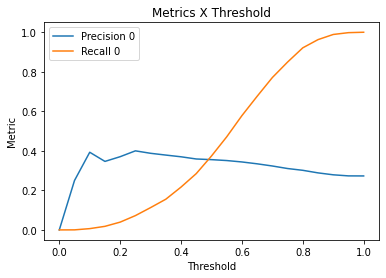

In [15]:
y_pred_proba_forest_rs = CV_forest_rs.best_estimator_.predict_proba(X_test)
y_pred_proba_forest_rs = np.delete(y_pred_proba_forest_rs, 0, 1)
thresholds = np.arange(0.0, 1.05, 0.05)
metrics_per_threshold_forest_rs = []

for threshold in thresholds:
    y_pred_forest_rs = y_pred_proba_forest_rs.copy()
    for row in range(len(y_pred_forest_rs)):
        if y_pred_forest_rs[row] > threshold:
            y_pred_forest_rs[row] = 1
        else:
            y_pred_forest_rs[row] = 0
    precision_0 = classification_report(y_true=y_test, y_pred=y_pred_forest_rs, output_dict=True)['0']['precision']
    recall_0 = classification_report(y_true=y_test, y_pred=y_pred_forest_rs, output_dict=True)['0']['recall']
    metrics_per_threshold_forest_rs.append([threshold, precision_0, recall_0])
metrics_per_threshold_forest_rs

print('***   FOREST - COM SMOTE TARGET - THRESHOLD = 0 ~ 1   ***')
plt.plot(np.array(metrics_per_threshold_forest_rs)[:,0], np.array(metrics_per_threshold_forest_rs)[:,1])
plt.plot(np.array(metrics_per_threshold_forest_rs)[:,0], np.array(metrics_per_threshold_forest_rs)[:,2])
plt.title('Metrics X Threshold')
plt.ylabel('Metric')
plt.xlabel('Threshold')
plt.legend(['Precision 0', 'Recall 0'], loc='best')
plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.613


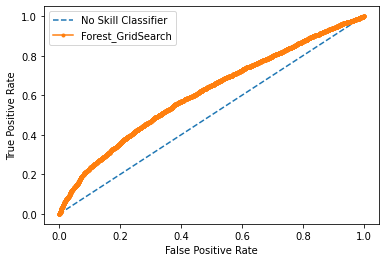

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#It returns the AUC score between 0.0 and 1.0 for no skill and perfect skill respectively.

# ROC AUC for Random Forest with RandomSearch
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = forest_rs.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill Classifier')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Forest_GridSearch')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## 2. AdaBoost

## 2.1. The model

In [20]:
Xa = data.drop(columns=['Loan.Status', 'Years.since.last.delinquent',
                      'Credit.Minus.Loan', 'Bankruptcies.enc', 'Tax.Liens.Enc'])
ya = data['Loan.Status'] 

# Train Test Split both datasets
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa, ya, test_size=0.3, random_state=42)

# GERACAO DE DADOS ARTIFICIAIS PARA A CATEGORIA DO TARGET MINORITARIO 0 A PARTIR DOS DADOS EXISTENTES
sm = SMOTE()
Xa_train_bal, ya_train_bal = sm.fit_resample(Xa_train, ya_train)

In [21]:
# AdaBoostClassifier model

DTC = DecisionTreeClassifier(max_depth = None)

ada = AdaBoostClassifier(base_estimator=DTC)

ada_cv = cross_validate(ada,
                          Xa_train_bal,
                          ya_train_bal,
                          scoring='f1_weighted',
                          cv=10)

ada.fit(Xa_train_bal, ya_train_bal)
ada.score(Xa_test, ya_test)

y_pred_ada = ada.predict(Xa_test)

print('ADABOOST - CLASSIFICATION REPORT')
print(classification_report(ya_test, y_pred_ada))

ADABOOST - CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.33      0.47      0.38      3373
           1       0.76      0.64      0.69      8980

    accuracy                           0.59     12353
   macro avg       0.54      0.55      0.54     12353
weighted avg       0.64      0.59      0.61     12353



In [22]:
pd.DataFrame(y_pred_ada).value_counts()

1    7507
0    4846
dtype: int64

## 2.2. Feature selection

In [23]:
#Feature selection using permutation importance

#perm_score_ada = permutation_importance(ada, Xa_train_bal, ya_train_bal, random_state=42, n_repeats=10)
#perm_score_ada['importances_mean']
#pd.DataFrame({'features': Xa.columns, 'importance_mean': perm_score_ada['importances_mean']}).sort_values('importance_mean')

## 2.3. GridSearch

In [25]:
#RandomSearch for ada_model

DTC = DecisionTreeClassifier(max_depth = None)

ada = AdaBoostClassifier(base_estimator=DTC)

param_grid_ada = {'base_estimator__criterion': ['gini', 'entropy'],
                  'base_estimator__splitter': ['random'],
                  'base_estimator__random_state':[42],
                  'n_estimators':[500, 750, 1000],
                  'learning_rate':[0.1, 0.5],
                  'random_state':[0],
                 }

CV_ada = GridSearchCV(ada, param_grid_ada,cv=10, 
                            verbose=1, n_jobs=-1)
CV_ada.fit(Xa_train_bal, ya_train_bal)
print(CV_ada.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   12.4s finished


{'base_estimator__criterion': 'gini', 'base_estimator__random_state': 42, 'base_estimator__splitter': 'random', 'learning_rate': 0.1, 'n_estimators': 500, 'random_state': 0}


## 2.4. Model with best_params_

In [32]:
#Applied GridSearchCV (rs)
DTC_rs = DecisionTreeClassifier(random_state=42,
                             criterion='gini',
                             splitter='random',
                             max_depth = None)

ada_rs = AdaBoostClassifier(base_estimator=DTC_rs,
                            random_state=0,
                            n_estimators=500,
                            learning_rate=0.1)

cv_ada_rs = cross_validate(ada_rs,
                          Xa_train_bal,
                          ya_train_bal,
                          scoring='f1_weighted',
                          cv=10)

# Model fit, score and score metrics
ada_rs.fit(Xa_train_bal, ya_train_bal)
ada_rs.score(Xa_test, ya_test)
y_pred_ada_rs = ada_rs.predict(Xa_test)

print('ADABOOST  W/ FEATURE SELECTION & RANDOM SEARCH - CLASSIFICATION REPORT')
print(classification_report(ya_test, y_pred_ada_rs))

ADABOOST  W/ FEATURE SELECTION & RANDOM SEARCH - CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.31      0.41      0.35      3373
           1       0.75      0.66      0.70      8980

    accuracy                           0.59     12353
   macro avg       0.53      0.53      0.53     12353
weighted avg       0.63      0.59      0.60     12353



c:\users\m_day\.venvs\lewagon\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***   ADABOOST - COM SMOTE TARGET - THRESHOLD = 0 ~ 1   ***


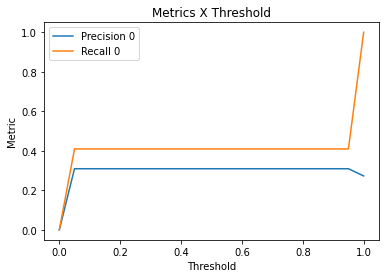

In [33]:
y_pred_proba_ada_rs = CV_ada.best_estimator_.predict_proba(Xa_test)
y_pred_proba_ada_rs = np.delete(y_pred_proba_ada_rs, 0, 1)
thresholds = np.arange(0.0, 1.05, 0.05)
metrics_per_threshold_ada_rs = []

for threshold in thresholds:
    y_pred_ada_rs = y_pred_proba_ada_rs.copy()
    for row in range(len(y_pred_ada_rs)):
        if y_pred_ada_rs[row] > threshold:
            y_pred_ada_rs[row] = 1
        else:
            y_pred_ada_rs[row] = 0
    precision_0 = classification_report(y_true=ya_test, y_pred=y_pred_ada_rs, output_dict=True)['0']['precision']
    recall_0 = classification_report(y_true=ya_test, y_pred=y_pred_ada_rs, output_dict=True)['0']['recall']
    metrics_per_threshold_ada_rs.append([threshold, precision_0, recall_0])
metrics_per_threshold_ada_rs

print('***   ADABOOST - COM SMOTE TARGET - THRESHOLD = 0 ~ 1   ***')
plt.plot(np.array(metrics_per_threshold_ada_rs)[:,0], np.array(metrics_per_threshold_ada_rs)[:,1])
plt.plot(np.array(metrics_per_threshold_ada_rs)[:,0], np.array(metrics_per_threshold_ada_rs)[:,2])
plt.title('Metrics X Threshold')
plt.ylabel('Metric')
plt.xlabel('Threshold')
plt.legend(['Precision 0', 'Recall 0'], loc='best')
plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.533


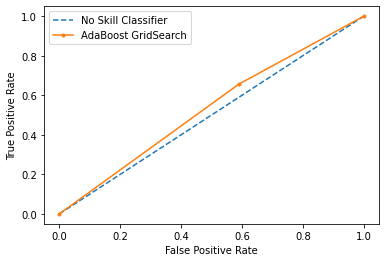

In [34]:
#It returns the AUC score between 0.0 and 1.0 for no skill and perfect skill respectively.

# ROC AUC for Random Forest with RandomSearch
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(ya_test))]
# predict probabilities
lr_probs = ada_rs.predict_proba(Xa_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(ya_test, ns_probs)
lr_auc = roc_auc_score(ya_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(ya_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(ya_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill Classifier')
plt.plot(lr_fpr, lr_tpr, marker='.', label='AdaBoost GridSearch')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## 3. XGBoost

## 3.1. The model

In [48]:
Xx = data.drop(columns=['Loan.Status', 'Tax.Liens.Enc'])
yx = data['Loan.Status'] 

# Train Test Split both datasets
Xx_train, Xx_test, yx_train, yx_test = train_test_split(Xx, yx, test_size=0.3, random_state=42)

# GERACAO DE DADOS ARTIFICIAIS PARA A CATEGORIA DO TARGET MINORITARIO 0 A PARTIR DOS DADOS EXISTENTES
sm = SMOTE()
Xx_train_bal, yx_train_bal = sm.fit_resample(Xx_train, yx_train)

In [49]:
#XGBoost model
xgb = XGBClassifier()

xgb.fit(Xx_train_bal, yx_train_bal)
xgb.score(Xx_test, yx_test)

yx_pred_xgb = xgb.predict(Xx_test)
print('XGBOOST - CLASSIFICATION REPORT')
print(classification_report(yx_test, yx_pred_xgb))

XGBOOST - CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.34      0.41      0.37      3373
           1       0.76      0.70      0.73      8980

    accuracy                           0.62     12353
   macro avg       0.55      0.55      0.55     12353
weighted avg       0.64      0.62      0.63     12353



In [50]:
pd.DataFrame(y_pred_xgb).value_counts()

1    8277
0    4076
dtype: int64

## 3.2. Feature selection

In [47]:
#Feature selection using permutation importance

#perm_score_xgb = permutation_importance(xgb, Xx_train_bal, yx_train_bal, random_state=42, n_repeats=10)
#perm_score_xgb['importances_mean']
#pd.DataFrame({'features': Xx.columns, 'importance_mean': perm_score_xgb['importances_mean']}).sort_values('importance_mean')

,features,importance_mean
2,Tax.Liens.Enc,0.000005
4,Bankruptcies.enc,0.001704
16,Purp.Buy House,0.002033
17,Purp.Buy a Car,0.002254
20,Purp.Medical Bills,0.002452
13,H.O.Own Home,0.002726
15,Purp.Business Loan,0.003556
19,Purp.Home Improvements,0.003833
9,Number.of.Credit.Problems.Labeled,0.004835
14,H.O.Rent,0.005297


## 3.3. GridSearch

In [58]:
#param_grid_xgb = {'learning_rate':[0.1, 0.5],
#                  'booster':['gbtree'],
#                  'gamma': [0.001],
#                  'n_estimators': [150,200],
#                }

#CV_xgb = GridSearchCV(xgb_model, param_grid_xgb, 
#                      scoring='f1_weighted', 
#                      cv=10, verbose=1, n_jobs=-1)
#CV_xgb.fit(Xx_train_bal, yx_train_bal)
#print(CV_xgb.best_params_)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.7min finished


{'booster': 'gbtree', 'gamma': 0.001, 'learning_rate': 0.5, 'n_estimators': 200}


## 3.4. Model with best_params_

In [59]:
#Applied GridSearchCV (rs)
xgb_rs = XGBClassifier(learning_rate=0.5,
                      booster='gbtree',
                      gamma=0.001,
                      n_estimators=200)

xgb_rs.fit(Xx_train_bal, yx_train_bal)
xgb_rs.score(Xx_test, yx_test)
yx_pred_xgb_rs = xgb_rs.predict(Xx_test)

print('XGBOOST - CLASSIFICATION REPORT')
print(classification_report(yx_test, yx_pred_xgb_rs))

XGBOOST - CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.34      0.33      0.33      3373
           1       0.75      0.76      0.76      8980

    accuracy                           0.64     12353
   macro avg       0.54      0.54      0.54     12353
weighted avg       0.64      0.64      0.64     12353



***   XGB - COM SMOTE - THRESHOLD = 0 ~ 1   ***


c:\users\m_day\.venvs\lewagon\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


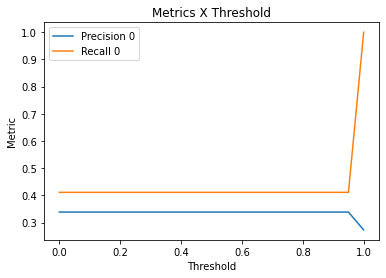

In [60]:
y_pred_proba_xgb = CV_xgb.best_estimator_.predict_proba(Xx_test)
y_pred_proba_xgb = np.delete(y_pred_proba_xgb, 0, 1)
thresholds = np.arange(0.0, 1.05, 0.05)
metrics_per_threshold_xgb = []

for threshold in thresholds:
    y_pred_xgb = y_pred_proba_xgb.copy()
    for row in range(len(yx_pred_xgb)):
        if yx_pred_xgb[row] > threshold:
            yx_pred_xgb[row] = 1
        else:
            yx_pred_xgb[row] = 0
    precision_0 = classification_report(y_true=yx_test, y_pred=yx_pred_xgb, output_dict=True)['0']['precision']
    recall_0 = classification_report(y_true=yx_test, y_pred=yx_pred_xgb, output_dict=True)['0']['recall']
    metrics_per_threshold_xgb.append([threshold, precision_0, recall_0])
metrics_per_threshold_xgb

print('***   XGB - COM SMOTE - THRESHOLD = 0 ~ 1   ***')
plt.plot(np.array(metrics_per_threshold_xgb)[:,0], np.array(metrics_per_threshold_xgb)[:,1])
plt.plot(np.array(metrics_per_threshold_xgb)[:,0], np.array(metrics_per_threshold_xgb)[:,2])
plt.title('Metrics X Threshold')
plt.ylabel('Metric')
plt.xlabel('Threshold')
plt.legend(['Precision 0', 'Recall 0'], loc='best')
plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.568


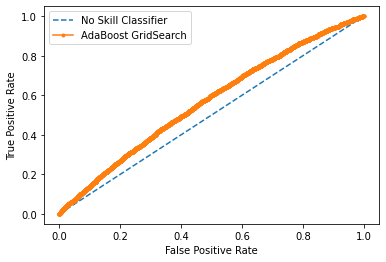

In [61]:
#It returns the AUC score between 0.0 and 1.0 for no skill and perfect skill respectively.

# ROC AUC for Random Forest with RandomSearch
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(yx_test))]
# predict probabilities
lr_probs = xgb_rs.predict_proba(Xx_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(yx_test, ns_probs)
lr_auc = roc_auc_score(yx_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(yx_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(yx_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill Classifier')
plt.plot(lr_fpr, lr_tpr, marker='.', label='AdaBoost GridSearch')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()